## Intalling dependencies

Model Maker for the Audio domain needs TensorFlow 2.5 to work.

In [1]:
! pip install tflite-model-maker

     |████████████████████████████████| 593kB 27.7MB/s 
     |████████████████████████████████| 122kB 37.8MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 849kB 50.5MB/s 
     |████████████████████████████████| 1.2MB 51.4MB/s 
     |████████████████████████████████| 645kB 51.6MB/s 
     |████████████████████████████████| 686kB 45.6MB/s 
     |████████████████████████████████| 1.1MB 51.4MB/s 
     |████████████████████████████████| 174kB 58.0MB/s 
     |████████████████████████████████| 6.3MB 47.5MB/s 
     |████████████████████████████████| 112kB 59.0MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 358kB 48.9MB/s 
     |████████████████████████████████| 194kB 55.7MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=42c0f1405f9ac2030b24d

In [2]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.5.0
Model Maker Version: 0.3.2


In [3]:
!nvidia-smi

Fri Jun 18 05:35:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Download folder and unzip it
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


## Training the Model

When using Model Maker for audio, you have to start with a model spec. This is the base model that your new model will extract information to learn about the new classes. It also affects how the dataset will be transformed to respect the models spec parameters like: sample rate, number of channels.

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

It's input is expected to be at 16kHz and with 1 channel.

You don't need to do any resampling yourself. Model Maker takes care of that for you.

- `frame_length` is to decide how long each traininng sample is. in this case EXPECTED_WAVEFORM_LENGTH * 1s

- `frame_steps` is to decide how far appart are the training samples. In this case, the ith sample will start at EXPECTED_WAVEFORM_LENGTH * 1s after the (i-1)th sample.

The reason to set these values is to work around some limitation in real world dataset.



In [5]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=2 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmpdiudnl17


## Loading the data

Model Maker has the API to load the data from a folder and have it in the expected format for the model spec.

The train set is based on the folders. The validation dataset will be created as 20% of the train split.

Note: The `cache=True` is important to make training later faster but it will also require more RAM to hold the data.


In [6]:
train_data = audio_classifier.DataLoader.from_folder(spec, data_dir, cache=True)
train_data, validation_data = train_data.split(0.8)

In [7]:
print(type(train_data))
print(len(train_data))
print(train_data.gen_dataset().take(1))

#for i in train_data.gen_dataset().take(1):
 # print(i)

<class 'tensorflow_examples.lite.model_maker.core.data_util.audio_dataloader.DataLoader'>
6400
<TakeDataset shapes: ((None, 1024), (None, 8)), types: (tf.float32, tf.float32)>


## Training the model

The audio_classifier has the [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) method that creates a model and already start training it. 

You can customize many parameterss, for more information you can read more details in the documentation.

On this first try you'll use all the default configurations and train for 40 epochs.

Note: The first epoch takes longer than all the other ones because it's when the cache is created. After that each epoch takes a few seconds.

In [8]:
batch_size = 32
epochs = 40

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classification_head (Dense)  (None, 8)                 8200      
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
184/184 [==============================] - 86s 445ms/step - loss: 2.0403 - acc: 0.2039 - val_loss: 1.9178 - val_acc: 0.2969
Epoch 2/40
184/184 [==============================] - 1s 7ms/step - loss: 1.8967 - acc: 0.2916 - val_loss: 1.8293 - val_acc: 0.3347
Epoch 3/40
184/184 [==============================] - 1s 7ms/step - loss: 1.8327 - acc: 0.3294 - val_loss: 1.7873 - val_acc: 0.3704
Epoch 4/40
184/184 [==============================] - 1s 7ms/step - loss: 1.7881 - acc: 0.3456 - val_loss: 1.7580 - val_acc: 0.3876
Epoch 5/40
184/184 [==============================] - 1s 7ms/step - loss: 1.7553 - acc: 0.3557 - v

In [9]:
print('Evaluating the model')
model.evaluate(validation_data)

Evaluating the model
46/46 [==============================] - 16s 336ms/step - loss: 1.5266 - acc: 0.4687


[1.526577115058899, 0.46872851252555847]

## Understanding your model

When training a classifier, it's useful to see the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed knowledge of how your classifier is performing on test data.

Model Maker already creates the confusion matrix for you.

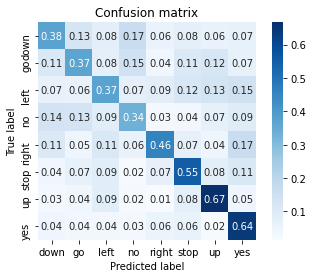

In [10]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(validation_data)
show_confusion_matrix(confusion_matrix.numpy(), validation_data.index_to_label)

In [11]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(1, 521) dtype=float32 (created by layer 'keras_layer')>, <KerasTensor: shape=(1, 8) dtype=float32 (created by layer 'sequential')>]


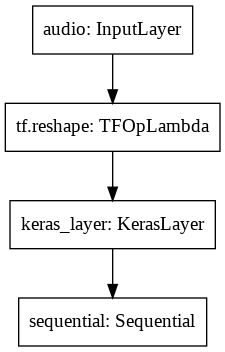

In [12]:
tf.keras.utils.plot_model(serving_model)

In [13]:
serving_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio (InputLayer)           [(None, 15600)]           0         
_________________________________________________________________
tf.reshape (TFOpLambda)      (15600,)                  0         
_________________________________________________________________
keras_layer (KerasLayer)     [(1, 521), (1, 1024), (96 0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 8200      
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________


In [14]:
saved_model_path = './yamnet_model_maker'
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./yamnet_model_maker/assets


INFO:tensorflow:Assets written to: ./yamnet_model_maker/assets


In [15]:
model.export('./yamnet_model_maker_saved_model', export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

INFO:tensorflow:Assets written to: ./yamnet_model_maker_saved_model/saved_model/assets


INFO:tensorflow:Assets written to: ./yamnet_model_maker_saved_model/saved_model/assets


INFO:tensorflow:Saving labels in ./yamnet_model_maker_saved_model/labels.txt


INFO:tensorflow:Saving labels in ./yamnet_model_maker_saved_model/labels.txt


In [16]:
reloaded_model = tf.saved_model.load('./yamnet_model_maker_saved_model/saved_model')
#reloaded_model.summary()

# Create tflite model

In [17]:
# Use with TF 2.5.0 with no quantization.
MODEL_PATH  = saved_model_path
MODEL_SAVE_PATH = "/content/yamnet_speech_commands.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)

tflite_model = converter.convert()
with tf.io.gfile.GFile(MODEL_SAVE_PATH, 'wb') as f:
  f.write(tflite_model)


# OR 
'''
models_path = '/content/yamnet_speech_commands'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='yamnet_speech_commands.tflite')
'''

"\nmodels_path = '/content/yamnet_speech_commands'\nprint(f'Exporing the TFLite model to {models_path}')\n\nmodel.export(models_path, tflite_filename='yamnet_speech_commands.tflite')\n"

# Test recorded audio

In [18]:
!pip install -q tensorflow_io
import tensorflow_io as tfio

commands = []
commands.append('down')
commands.append('go')
commands.append('left')
commands.append('no')
commands.append('right')
commands.append('stop')
commands.append('up')
commands.append('yes')

# Trancuate to 15600 length
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    print(sample_rate)
    # make it 15600 long (as it is expected from the model) and trancuate longer audio files
    wav = tf.squeeze(wav[:15600], axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

     |████████████████████████████████| 24.1MB 125kB/s 
     |████████████████████████████████| 2.5MB 49.4MB/s 


In [19]:
input = load_wav_16k_mono('/content/data/mini_speech_commands/right/012c8314_nohash_1.wav')
print(type(input))
print(input)

Tensor("DecodeWav:1", shape=(), dtype=int32)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[ 3.7431949e-08 -1.0590634e-07  2.6209841e-07 ...  8.0896067e-03
  7.8722648e-03  7.4156714e-03], shape=(15600,), dtype=float32)


In [20]:
# Inference with the saved model
yamnet_output, inference = serving_model(input)
print(yamnet_output.shape)
print()
print(inference)
print()
print(f'The main sound is: {commands[tf.argmax(inference[0])]}')

(1, 521)

tf.Tensor(
[[0.14870849 0.15466075 0.08991945 0.10079474 0.25935957 0.05587868
  0.08873598 0.10194238]], shape=(1, 8), dtype=float32)

The main sound is: right


In [21]:
# Inference with the tflite file
input_wav = input
# expand dimensions to match models expected input
input_wav = tf.expand_dims(input_wav, 0)
input_shape_size = input_wav.shape
print(input_shape_size)
interpreter = tf.lite.Interpreter(model_path=MODEL_SAVE_PATH)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

input_data = np.array(input_wav, dtype=np.float32)

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data[0])
result = commands[tf.argmax(output_data[0])]
print(f'The main sound is: {result}')

(1, 15600)
[{'name': 'serving_default_audio:0', 'index': 0, 'shape': array([    1, 15600], dtype=int32), 'shape_signature': array([   -1, 15600], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[0.14870921 0.15466025 0.08991931 0.10079473 0.25936007 0.05587831
 0.08873647 0.10194165]
The main sound is: right
